<a href="https://colab.research.google.com/github/jamesjyoon/llm_interpretability/blob/main/SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu  # For CPU; remove if GPU is enabled
!pip install transformers shap datasets matplotlib seaborn

Looking in indexes: https://download.pytorch.org/whl/cpu


In [ ]:

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (subset for speed)
dataset = load_dataset("glue", "sst2", split="validation[:100]")  # 100 samples for demo

# Load model and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Preprocess function
def preprocess(texts):
    if isinstance(texts, str):
        texts = [texts]
    elif not isinstance(texts, (list, tuple)):
        texts = list(texts)
    if not all(isinstance(t, str) for t in texts):
        raise ValueError(f"All elements must be strings, got {texts[:3]}")

    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
    return inputs

# Prepare data
texts = list(dataset["sentence"])
y = dataset["label"]

print(f"Type of texts: {type(texts)}, First few elements: {texts[:3]}")

X = preprocess(texts)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"Loaded {len(texts)} samples. Model on {device}.")
print(f"Sample text: {texts[0]} (Label: {'POS' if y[0] == 1 else 'NEG'})")

Type of texts: <class 'list'>, First few elements: ["it 's a charming and often affecting journey . ", 'unflinchingly bleak and desperate ', 'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ']
Loaded 100 samples. Model on cuda.
Sample text: it 's a charming and often affecting journey .  (Label: POS)


In [ ]:
# Step 4: Compute SHAP Values using Partition Explainer

# Create a prediction function that works with text strings
def predict_fn(texts):
    """
    Prediction function that takes text strings and returns probabilities
    """
    # Handle both single string and list of strings
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, np.ndarray):
        texts = texts.tolist()

    # Tokenize the texts
    inputs = tokenizer(texts,
                      return_tensors="pt",
                      truncation=True,
                      padding=True,
                      max_length=128)

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    return probs.cpu().numpy()

# Prepare data for SHAP
num_samples = 10
texts_subset = texts[:num_samples]

print(f"Number of texts: {len(texts_subset)}")

# Test the prediction function
test_preds = predict_fn(texts_subset[:2])
print(f"Test predictions shape: {test_preds.shape}")
print(f"Test predictions:\n{test_preds}")

# Use Partition Explainer with Text masker
print("\nCreating SHAP explainer...")

# Create a masker that understands text
masker = shap.maskers.Text(tokenizer)

# Create explainer
explainer = shap.Explainer(predict_fn, masker)

print(f"Computing SHAP values for {len(texts_subset)} samples...")
print("Note: This may take a few minutes...")

# Compute SHAP values
shap_values = explainer(texts_subset)

print(f"\n✓ Computed SHAP values!")
print(f"SHAP values shape: {shap_values.values.shape}")




Number of texts: 10
Test predictions shape: (2, 2)
Test predictions:
[[1.1603944e-04 9.9988389e-01]
 [9.9896955e-01 1.0304949e-03]]

Creating SHAP explainer...
Computing SHAP values for 10 samples...
Note: This may take a few minutes...

✓ Computed SHAP values!
SHAP values shape: (10,)



--- SHAP Text Visualization for Sample 0 (Positive Class) ---
Text: it 's a charming and often affecting journey . 
True label: POS



--- SHAP Waterfall Plot for Sample 0 ---


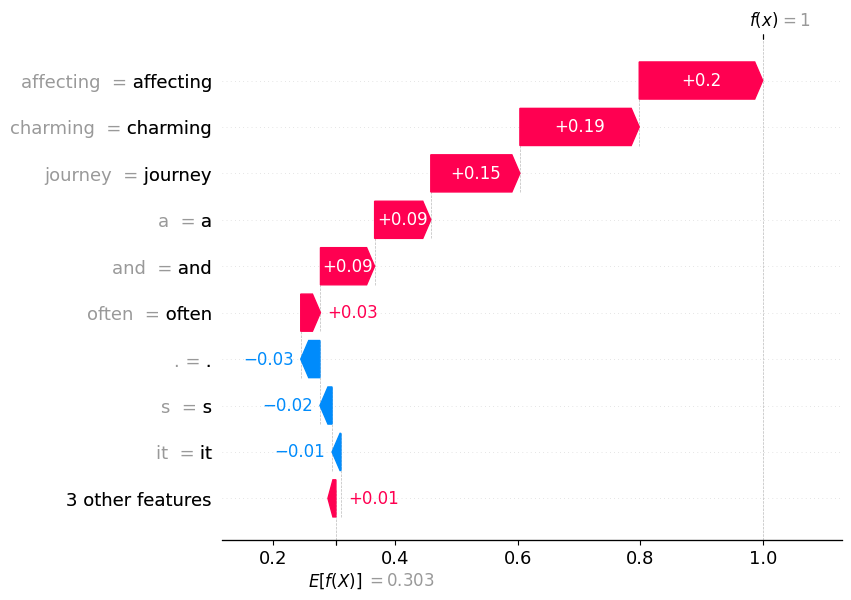


--- SHAP Bar Plot for Sample 0 ---
Bar plot failed: string index out of range


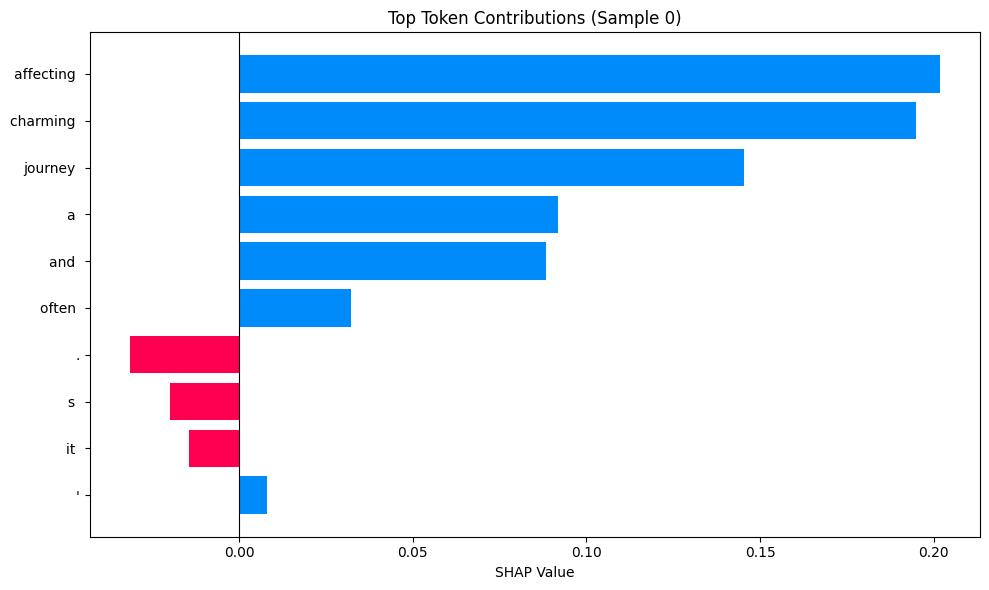


--- SHAP Summary Plot (Positive Class) ---
Beeswarm plot failed: operands could not be broadcast together with shapes (12,) (10,) 
Creating alternative summary visualization...


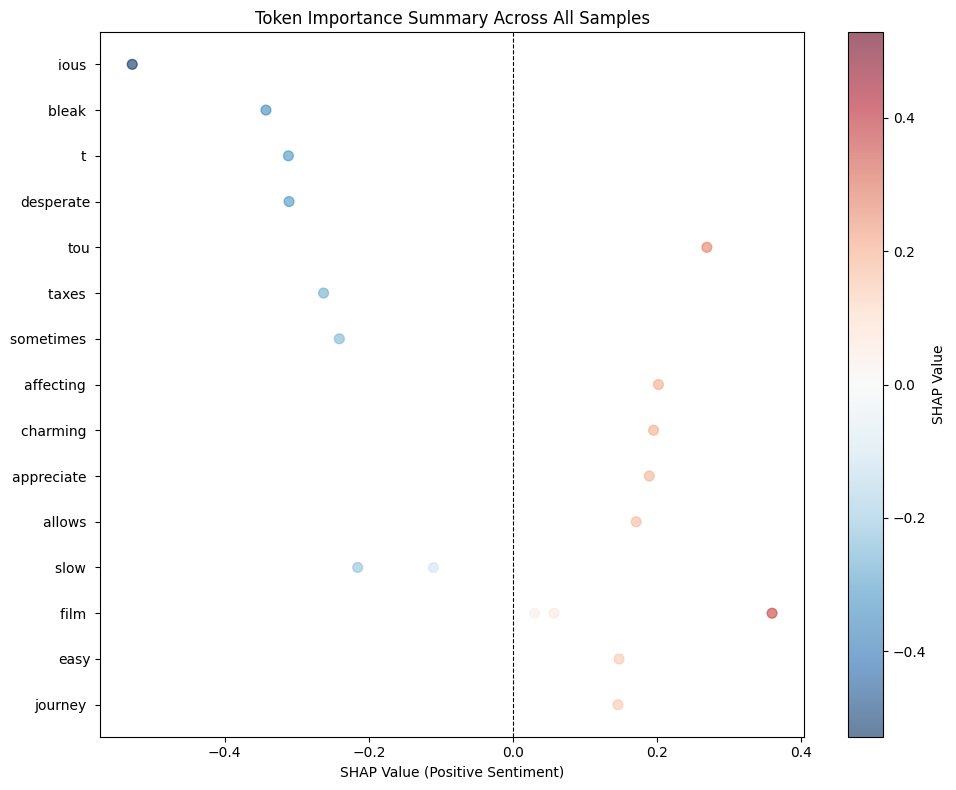


--- Token-level SHAP values for sample 0 ---
Text: it 's a charming and often affecting journey . 
True label: POS

Top 10 most influential tokens (positive sentiment):
  affecting           : +0.2017 → POS
  charming            : +0.1949 → POS
  journey             : +0.1455 → POS
  a                   : +0.0917 → POS
  and                 : +0.0884 → POS
  often               : +0.0322 → POS
  .                   : -0.0314 → NEG
  s                   : -0.0198 → NEG
  it                  : -0.0145 → NEG
  '                   : +0.0082 → POS

--- Token Analysis for Multiple Samples ---

Sample 0: it 's a charming and often affecting journey . 
True label: POS
Predicted: POS (POS prob: 1.000)

Top 5 influential tokens:
  affecting           : +0.2017 → POS
  charming            : +0.1949 → POS
  journey             : +0.1455 → POS
  a                   : +0.0917 → POS
  and                 : +0.0884 → POS

Sample 1: unflinchingly bleak and desperate 
True label: NEG
Predicted: NEG (PO

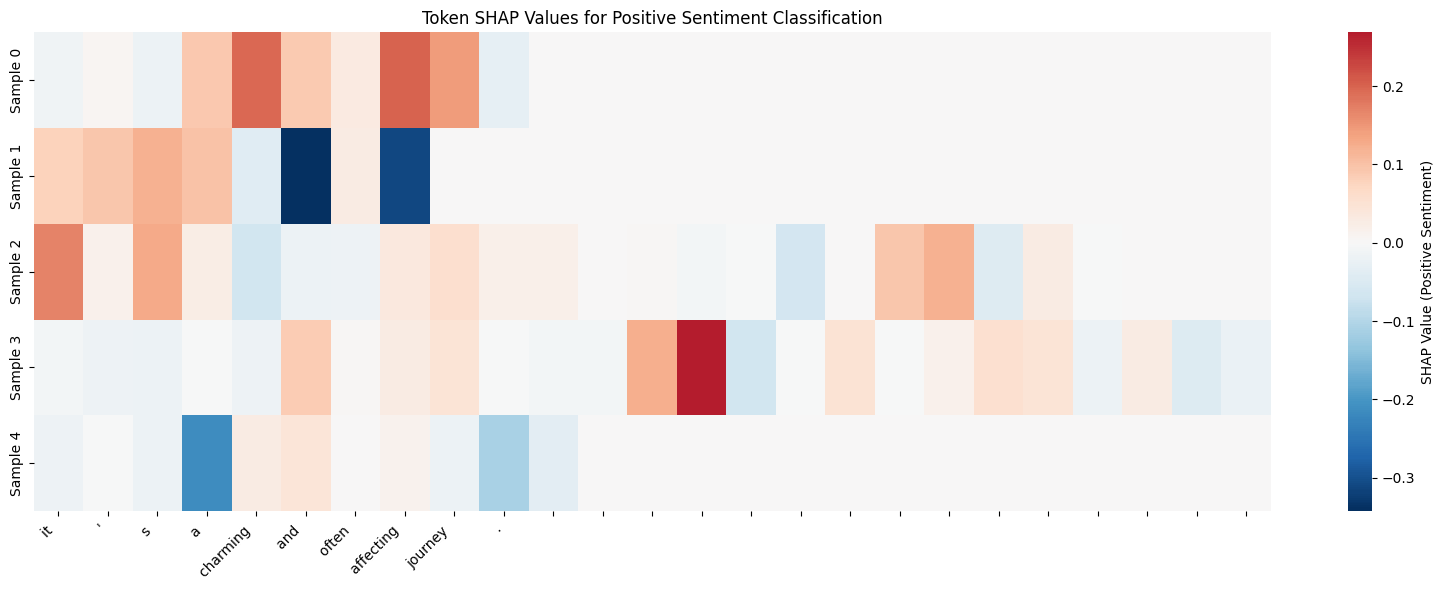


--- Average Token Importance ---


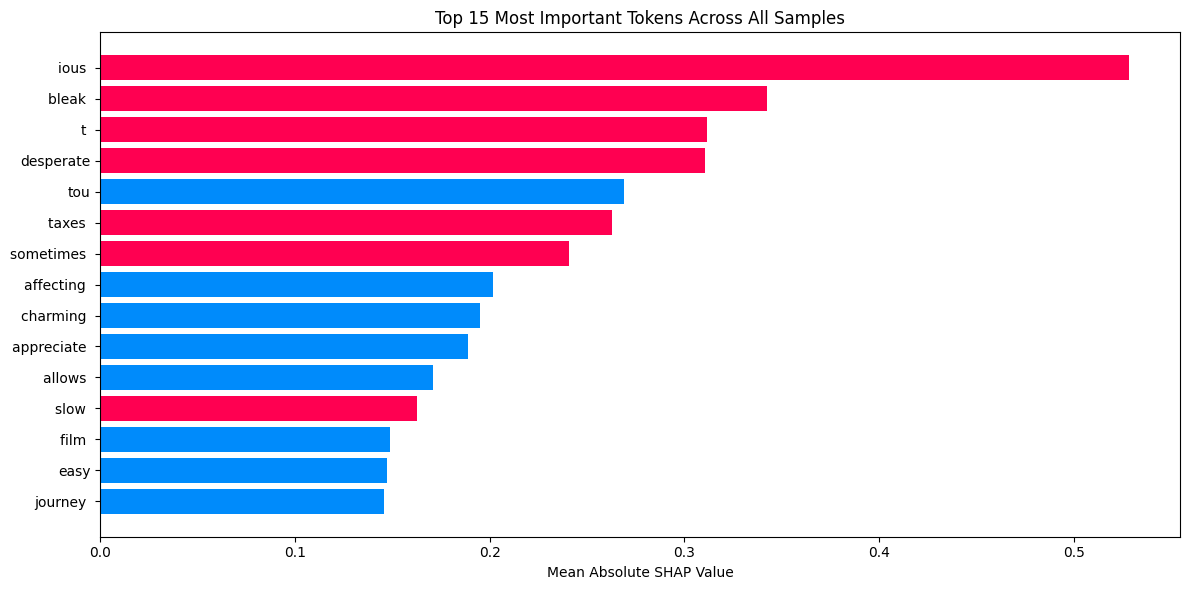


✓ SHAP analysis complete!


In [ ]:
# Step 5: Visualize SHAP Values
sample_idx = 0

# Text plot for positive class
print(f"\n--- SHAP Text Visualization for Sample {sample_idx} (Positive Class) ---")
print(f"Text: {texts[sample_idx]}")
print(f"True label: {'POS' if y[sample_idx] == 1 else 'NEG'}")
shap.plots.text(shap_values[sample_idx, :, 1])  # Index 1 is positive class

# Waterfall plot
print(f"\n--- SHAP Waterfall Plot for Sample {sample_idx} ---")
shap.plots.waterfall(shap_values[sample_idx, :, 1])

# Bar plot for first sample - fix the indexing
print(f"\n--- SHAP Bar Plot for Sample {sample_idx} ---")
try:
    shap.plots.bar(shap_values[sample_idx, :, 1], max_display=15)
except (IndexError, ValueError) as e:
    print(f"Bar plot failed: {e}")
    # Create custom bar plot instead
    sample_vals = shap_values[sample_idx, :, 1].values
    sample_toks = shap_values[sample_idx, :, 1].data

    # Filter and sort
    tok_val_pairs = [(str(t), v) for t, v in zip(sample_toks, sample_vals)
                     if t and str(t).strip()]
    tok_val_pairs.sort(key=lambda x: abs(x[1]), reverse=True)
    tok_val_pairs = tok_val_pairs[:15]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    tokens = [t for t, v in tok_val_pairs]
    values = [v for t, v in tok_val_pairs]
    colors = ['#ff0051' if v < 0 else '#008bfb' for v in values]

    ax.barh(tokens, values, color=colors)
    ax.set_xlabel('SHAP Value')
    ax.set_title(f'Top Token Contributions (Sample {sample_idx})')
    ax.axvline(x=0, color='black', linewidth=0.8)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

# Summary plot across all samples (beeswarm)
print(f"\n--- SHAP Summary Plot (Positive Class) ---")
try:
    shap.plots.beeswarm(shap_values[:, :, 1], max_display=15)
except (IndexError, ValueError) as e:
    print(f"Beeswarm plot failed: {e}")
    print("Creating alternative summary visualization...")

    # Create manual summary plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Collect all tokens and their SHAP values across samples
    all_tokens_list = []
    all_values_list = []

    for i in range(len(shap_values)):
        sample_vals = shap_values[i, :, 1].values
        sample_toks = shap_values[i, :, 1].data

        for tok, val in zip(sample_toks, sample_vals):
            if tok and str(tok).strip():
                all_tokens_list.append(str(tok))
                all_values_list.append(val)

    # Get unique tokens and their statistics
    from collections import defaultdict
    token_stats = defaultdict(list)
    for tok, val in zip(all_tokens_list, all_values_list):
        token_stats[tok].append(val)

    # Calculate mean absolute value for ranking
    token_importance = {tok: np.mean(np.abs(vals))
                       for tok, vals in token_stats.items()}

    # Get top 15 tokens
    top_tokens = sorted(token_importance.items(),
                       key=lambda x: x[1],
                       reverse=True)[:15]

    # Plot
    positions = []
    for i, (tok, _) in enumerate(top_tokens):
        vals = token_stats[tok]
        positions.extend([i] * len(vals))

    all_vals = []
    for tok, _ in top_tokens:
        all_vals.extend(token_stats[tok])

    scatter = ax.scatter(all_vals, positions,
                        c=all_vals, cmap='RdBu_r',
                        alpha=0.6, s=50,
                        vmin=-max(abs(np.array(all_vals))),
                        vmax=max(abs(np.array(all_vals))))

    ax.set_yticks(range(len(top_tokens)))
    ax.set_yticklabels([tok for tok, _ in top_tokens])
    ax.set_xlabel('SHAP Value (Positive Sentiment)')
    ax.set_title('Token Importance Summary Across All Samples')
    ax.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
    ax.invert_yaxis()

    plt.colorbar(scatter, ax=ax, label='SHAP Value')
    plt.tight_layout()
    plt.show()

# Custom visualization: Token importance
print(f"\n--- Token-level SHAP values for sample {sample_idx} ---")
print(f"Text: {texts[sample_idx]}")
print(f"True label: {'POS' if y[sample_idx] == 1 else 'NEG'}")

# Get token-level values for positive class
sample_values = shap_values[sample_idx, :, 1].values
sample_tokens = shap_values[sample_idx, :, 1].data

print("\nTop 10 most influential tokens (positive sentiment):")
token_shap_pairs = list(zip(sample_tokens, sample_values))
# Filter out None or empty tokens
token_shap_pairs = [(t, s) for t, s in token_shap_pairs if t and str(t).strip()]
# Sort by absolute SHAP value
token_shap_pairs.sort(key=lambda x: abs(x[1]), reverse=True)
for token, shap_val in token_shap_pairs[:10]:
    direction = "→ POS" if shap_val > 0 else "→ NEG"
    print(f"  {str(token):20s}: {shap_val:+.4f} {direction}")

# Visualize multiple samples
print(f"\n--- Token Analysis for Multiple Samples ---")
for i in range(min(3, num_samples)):
    print(f"\n{'='*80}")
    print(f"Sample {i}: {texts[i]}")
    print(f"True label: {'POS' if y[i] == 1 else 'NEG'}")

    # Get predictions
    pred_probs = predict_fn([texts[i]])[0]
    pred_label = "POS" if pred_probs[1] > pred_probs[0] else "NEG"
    print(f"Predicted: {pred_label} (POS prob: {pred_probs[1]:.3f})")

    sample_vals = shap_values[i, :, 1].values
    sample_toks = shap_values[i, :, 1].data

    tok_shap = list(zip(sample_toks, sample_vals))
    tok_shap = [(t, s) for t, s in tok_shap if t and str(t).strip()]
    tok_shap.sort(key=lambda x: abs(x[1]), reverse=True)

    print("\nTop 5 influential tokens:")
    for token, shap_val in tok_shap[:5]:
        direction = "→ POS" if shap_val > 0 else "→ NEG"
        print(f"  {str(token):20s}: {shap_val:+.4f} {direction}")

# Create a custom heatmap visualization
print(f"\n--- Creating Custom Heatmap ---")
fig, ax = plt.subplots(figsize=(16, 6))

# Get values for first 5 samples
n_viz = min(5, num_samples)
heatmap_data = []
token_labels = []
max_tokens = 0

# First pass: determine max number of tokens
for i in range(n_viz):
    sample_vals = shap_values[i, :, 1].values
    sample_toks = shap_values[i, :, 1].data

    # Keep only non-empty tokens
    toks = [str(t) for t in sample_toks if t and str(t).strip()]
    max_tokens = max(max_tokens, len(toks))

max_tokens = min(max_tokens, 25)  # Cap at 25 for readability

# Second pass: build heatmap data
for i in range(n_viz):
    sample_vals = shap_values[i, :, 1].values
    sample_toks = shap_values[i, :, 1].data

    # Keep only non-empty tokens
    vals = [v for t, v in zip(sample_toks, sample_vals) if t and str(t).strip()]
    toks = [str(t) for t in sample_toks if t and str(t).strip()]

    # Truncate to max_tokens
    vals = vals[:max_tokens]
    toks = toks[:max_tokens]

    # Pad if needed
    vals = vals + [0] * (max_tokens - len(vals))
    toks = toks + [''] * (max_tokens - len(toks))

    heatmap_data.append(vals)
    if i == 0:
        token_labels = toks

heatmap_data = np.array(heatmap_data)

sns.heatmap(heatmap_data,
            xticklabels=token_labels,
            yticklabels=[f"Sample {i}" for i in range(n_viz)],
            cmap='RdBu_r',
            center=0,
            annot=False,
            cbar_kws={'label': 'SHAP Value (Positive Sentiment)'},
            ax=ax)

plt.xticks(rotation=45, ha='right')
plt.title('Token SHAP Values for Positive Sentiment Classification')
plt.tight_layout()
plt.show()

# Create a summary bar chart of average token importance
print(f"\n--- Average Token Importance ---")
fig, ax = plt.subplots(figsize=(12, 6))

# Collect all token SHAP values
all_token_shaps = {}
for i in range(num_samples):
    sample_vals = shap_values[i, :, 1].values
    sample_toks = shap_values[i, :, 1].data

    for tok, val in zip(sample_toks, sample_vals):
        if tok and str(tok).strip():
            tok_str = str(tok).lower()
            if tok_str not in all_token_shaps:
                all_token_shaps[tok_str] = []
            all_token_shaps[tok_str].append(val)

# Calculate mean absolute SHAP value for each token
token_importance = {tok: np.mean(np.abs(vals))
                   for tok, vals in all_token_shaps.items()}

# Get top 15 tokens
top_tokens = sorted(token_importance.items(),
                   key=lambda x: x[1],
                   reverse=True)[:15]

tokens_list = [t[0] for t in top_tokens]
importance_list = [t[1] for t in top_tokens]

# Color based on average direction
colors = ['#ff0051' if np.mean(all_token_shaps[tok]) < 0 else '#008bfb'
         for tok in tokens_list]

ax.barh(tokens_list, importance_list, color=colors)
ax.set_xlabel('Mean Absolute SHAP Value')
ax.set_title('Top 15 Most Important Tokens Across All Samples')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✓ SHAP analysis complete!")